In [1]:
using Revise, CSV, DataFrames, PyPlot, Interpolations, HDF5, Statistics, Korg, StaticArrays, ProgressMeter

┌ Info: Precompiling Korg [acafc109-a718-429c-b0e5-afd7f8c7ae46]
└ @ Base loading.jl:1423


# re-format and store profiles

In [2]:
@time index = CSV.read("../StehleHutchson1999-hydrogen-stark-broadening/params.dat", 
    header=["lower", "upper", "lambda0", "Kalpha", "ne", "E0", "temp", "R0_Debye", "filename"], 
    delim=' ', ignorerepeated=true, DataFrame);
;

  6.592808 seconds (1.99 M allocations: 106.161 MiB, 0.37% gc time, 99.83% compilation time)


In [3]:
temps = Int.(sort(collect(Set(index.temp))))
;

In [4]:
function fterp(dir, temp, ne; siz=71)
    cd("/Users/aw/Dropbox/Korg_data/StehleHutchson1999-hydrogen-stark-broadening/")
    
    if temp == 2500
        #hack because the fortran code rejects 2500 for some reason
        temp += 1e-10
    end
    
    run(`cp a.out $dir`)
    cd(dir)
    open("input", "w") do file
        write(file, "$(temp)\n$(ne)")
    end
    output = readchomp(pipeline(`cat input`, `./a.out`))
    cd("../..")
    
    table = CSV.File(IOBuffer(codeunits(output)), skipto=15, delim=' ', ignorerepeated=true, 
        header=["detuning", "delta_nu", "fdop", "fraw"])
    if size(table) == (0,)
        fill(0, 2, siz)
    else
        if siz != length(table.delta_nu)
            #println(siz, " ", length(table.delta_nu))
        end
        [table.delta_nu' ; table.fdop']
    end
end


fterp (generic function with 1 method)

In [5]:
fname = "Stehle-Hutchson-hydrogen-profiles.h5"
#rm("./Stehle-Hutchson-hydrogen-profiles.h5")
groups = groupby(index, [:upper, :lower])
sizes = map(collect(groups)) do group
    size(fterp(group.filename[2][1:7], group.temp[2], group.ne[2]), 2)
end
@showprogress map(zip(collect(groups), sizes)) do (group, siz)
    temps = sort(collect(Set(group.temp)))
    nes = sort(collect(Set(group.ne)))
    
    #scatter(group.temp, group.ne)
    #title("$(group.lower[1]) to $(group.upper[1])")
    #xscale("log")
    #yscale("log")
    
    A = fill(0.0, length(temps), length(nes), siz)
    L0 = fill(0.0, length(temps), length(nes))
    for (i, temp) in enumerate(temps), (j, ne) in enumerate(nes)
        rows = group[(group.temp .== temp) .& (group.ne .== ne), :]
        if size(rows, 1) == 1
            row = rows[1, :]
            A[i,j, :] .= fterp(row.filename[1:7], row.temp, row.ne; siz=siz)[2, :]
            L0[i,j] = row.lambda0
        end
    end
    
    row = group[1, :]
    Δνs = fterp(row.filename[1:7], row.temp, row.ne; siz=siz)[1, :]
    F0 = 1.25e-9 * row.ne^(2/3)
    
    h5open(fname, "cw") do fid
        transition = "$(group.lower[1])_$(group.upper[1])"
        #println(transition)
        fid[transition*"/profile"] = A
        fid[transition*"/lambda0"] = L0
        fid[transition*"/electron_number_densities"] = nes
        fid[transition*"/delta_nu_over_F0"] = Δνs ./ F0
        fid[transition*"/temps"] = temps
        h5writeattr(fname, transition, Dict(
                "lower"=>group.lower[1], 
                "upper"=>group.upper[1]))
    end
end
;

Progress: 100%|█████████████████████████████████████████| Time: 0:14:12


### add $K_\omega$ and $log~gf~$  to the HDF5 file

In [6]:
Hlines = CSV.read("Hlines.vald", DataFrame, skipto=3, footerskip=3,
    header=[:spec, :wl, :E, :log_gf, :rad, :stark, :vdW])
;

┌ Warning: thread = 1 warning: parsed expected 7 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV /Users/aw/.julia/packages/CSV/jFiCn/src/file.jl:579


In [7]:
#this will fail if the attribute are already defined.

cd("/Users/aw/Dropbox/Korg_data/StehleHutchson1999-hydrogen-stark-broadening/")
fname = "Stehle-Hutchson-hydrogen-profiles.h5"
h5open(fname, "r+") do fid
    @showprogress for key in keys(fid)
        i = findfirst(eachrow(index)) do row
            row.lower == HDF5.read_attribute(fid[key], "lower")
            row.upper == HDF5.read_attribute(fid[key], "upper")
        end
        K = index[i, "Kalpha"]
        
        lambda0 = read(fid[key], "lambda0")[1]
        j = argmin(abs.([line.wl for line in eachrow(Hlines)] .- lambda0))
        #println("λ₀ = $(lambda0), Δλ = $(Hlines.wl[j] - lambda0)")
        if "log_gf" in keys(attributes(fid[key]))
            println(attributes(fid[key])["log_gf"], " ", Hlines.log_gf[j])
            delete_attribute(fid[key], "log_gf")
        end
        attributes(fid[key])["log_gf"] = Hlines.log_gf[j]
        attributes(fid[key])["Kalpha"] = Hlines.log_gf[j]
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


# load and use profiles

In [8]:
profiles = Korg._load_stark_profiles("Stehle-Hutchson-hydrogen-profiles.h5");

In [10]:
for transition in profiles
    println(any(isnan.(transition.profile.itp.coefs)))
end

false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false


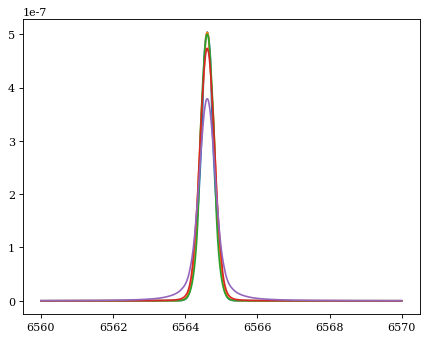

In [21]:
wls = (6560:0.01:6570) .* 1e-8 
for ne in 10 .^ (11:15)
    αs = zeros(length(wls))
    Korg.hydrogen_line_absorption!(αs, wls, 10_000.0, ne, 1e10, 1.0, 1e5, 15e-7; stark_profiles=profiles)
    plot(wls * 1e8, αs)
end

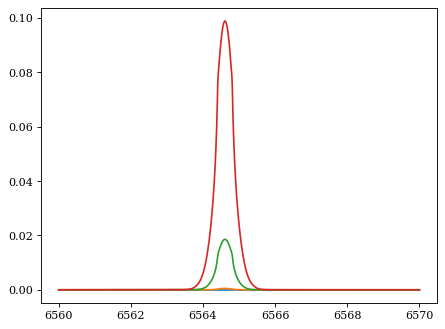

In [22]:
wls = (6560:0.01:6570) .* 1e-8
for T in [5000, 10_000, 15_000, 20_000]
    αs = zeros(length(wls))
    Korg.hydrogen_line_absorption!(αs, wls, T, 1e13, 1e13, 1.0, 1e5, 15e-7; stark_profiles=profiles)
    plot(wls * 1e8, αs)
end

# compare to fortran code output

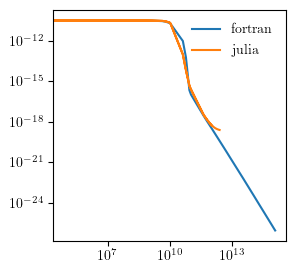

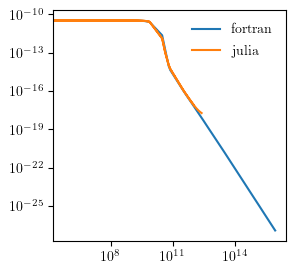

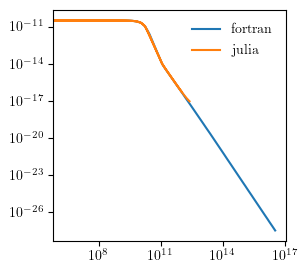

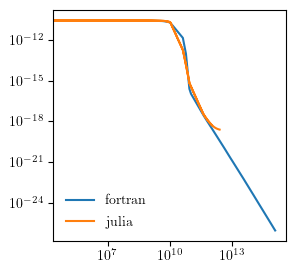

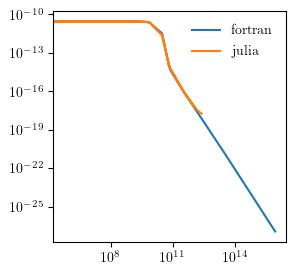

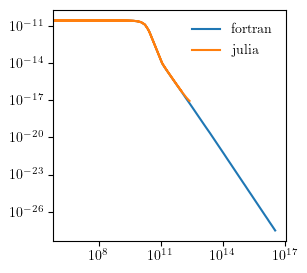

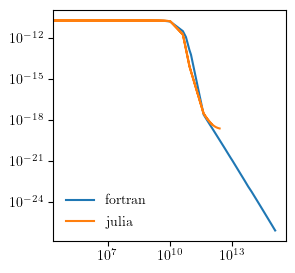

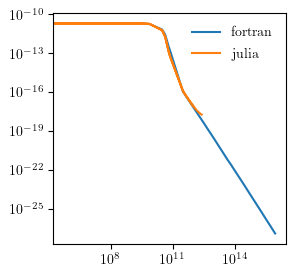

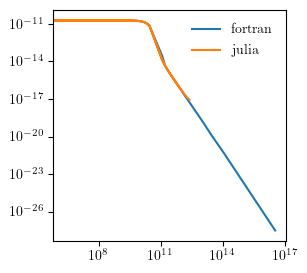

In [414]:
for T in [8003.4, 10000, 24321], ne in [2e11, 4e12, 3e13]
    figure(figsize=(3,3))
    
    P = fterp("ba/ba03/", T, ne)
    plot(P[1, :], P[2, :], label="fortran")
    xscale("log")
    yscale("log")

    wls = (6550:0.01:6600) .* 1e-8
    αs = hydrogen_line_absorption(wls, T, ne)
    nus = Korg.c_cgs ./ wls
    dλdν = wls.^2 ./ Korg.c_cgs
    plot(abs.(nus .- (Korg.c_cgs / (6564.7*1e-8))), αs .* dλdν, label="julia")

    legend()
end

# save profile for Korg tests

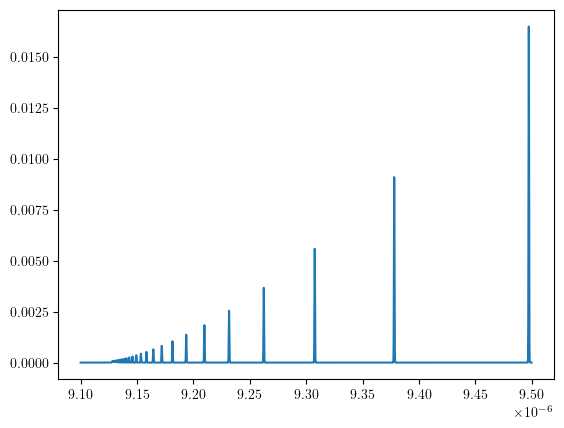

  0.007254 seconds (561 allocations: 1.537 MiB)


In [3]:
#wls = (1020:0.01:1032) .* 1e-8
wls = (910:0.01:950) .* 1e-8
@time αs = Korg.hydrogen_line_absorption(wls, 9000.0, 1e11, 1e13, Korg.partition_funcs[Korg.literals.H_I], 
    Korg.hline_stark_profiles, 0.0)
plot(wls, αs)

fname = "lyman_absorption.h5"
h5write(fname, "profile", αs)
h5writeattr(fname, "profile", Dict("start_wl"=>910*1e-8, "stop_wl"=>950*1e-8, "wl_step"=>0.01*1e-8, "T"=>9000.0, 
        "ne"=>1e11, "nH_I"=>1e13))